# Загрузка нужных библиотек

In [ ]:
!pip install transformers==3.5.1
!pip install torch==1.7.0
!pip install scikit-learn==0.23.2

In [ ]:
import random, torch
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
import math
import os
import re
import time

from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.cluster import AgglomerativeClustering
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

# Параметры

Сначала дообучим добавленный линейный слой. Дальше поочередно размораживаем и дообучаем каждый слой distilbert.

In [ ]:
# Нужно указать путь до папки, в которую сохранили дообученную модель на задаче
# языкового моделирования, или название предобученой модели (huggingface)
MODEL_NAME_PRETRAINED = 'mlm1500000'
DO_LOWERCASE = True
BATCH_SIZE = 64
LEARNING_RATE = [5e-5, 4e-5, 4e-5, 3e-5, 3e-5, 2e-5, 1e-5]
DROPOUT_CLASS = 0.1
HIDDEN_SIZE_ENC = 768
DIR_OUT = 'distilbert_uncased_for_pseudolab'
MODEL_NAME = os.path.join(DIR_OUT, 'bert_model')
N_EPOCHS = [10, 4, 4, 4, 3, 2, 2]

In [ ]:
!mkdir $DIR_OUT

# Подготовка данных

In [ ]:
# Загружаем исходные данные из паркет-файла и выполняем небольшую предобработку
def replace_re(text, regexp, inplace): 
    return regexp.sub(inplace, text)

data = pd.read_parquet("data/data_fusion_train.parquet", columns=['item_name', 'category_id'])
data = data[data.category_id != -1]
    
regex_punc = re.compile('[%s]'%re.escape('.,!?'))
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_punc, ' '))
regex_seq_spaces = re.compile(' {2,}')
data['item_name'] = data['item_name'].apply(lambda x: x.strip())
data['item_name'] = data['item_name'].apply(lambda x: replace_re(x, regex_seq_spaces, ' '))
data['item_name'] = data['item_name'].apply(lambda x: x.lower())
data = data.drop_duplicates('item_name')
print(data.shape)


(47790, 2)


In [ ]:
order_labels = pd.unique(data.category_id)
order_labels.sort()
dict_labels = {idx:x for idx, x in enumerate(order_labels)}          # порядковый номер: класс
inverse_dict_labels = {dict_labels[idx]:idx for idx in dict_labels}  # класс: порядковый номер

data['y_true'] = data['category_id'].apply(lambda x: inverse_dict_labels[x])

In [ ]:
# Подготовим данные для псевдо разметки
data_no_lab = pd.read_parquet("data/data_fusion_train.parquet", columns=['item_name', 'category_id'])
data_no_lab = data_no_lab[data_no_lab.category_id == -1]
regex_punc = re.compile('[%s]'%re.escape('.,!?'))
data_no_lab['item_name'] = data_no_lab['item_name'].apply(lambda x: replace_re(x, regex_punc, ' '))
data_no_lab['item_name'] = data_no_lab['item_name'].apply(lambda x: x.strip())
regex_seq_spaces = re.compile(' {2,}')
data_no_lab['item_name'] = data_no_lab['item_name'].apply(lambda x: replace_re(x, regex_seq_spaces, ' '))
data_no_lab['item_name'] = data_no_lab['item_name'].apply(lambda x: x.lower())
data_no_lab = data_no_lab.drop_duplicates('item_name')

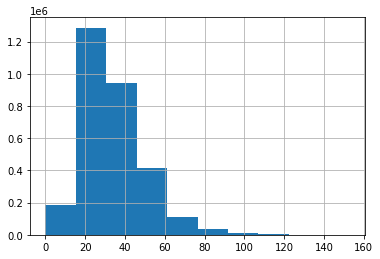

In [ ]:
data_no_lab.item_name.apply(len).hist()

In [ ]:
# Для псевдо разметки оставим item_name, длина которых больше 18 и меньше 80 символов
data_no_lab = data_no_lab[(data_no_lab.item_name.apply(len) > 18) & (data_no_lab.item_name.apply(len) < 80)]
data_nolabel = data_no_lab[~data_no_lab.item_name.isin(data.item_name)]
data_nolabel.shape

(2606828, 2)

# Подготовка модели

In [ ]:
class BertForMultiClassSequenceClassification(nn.Module):
    
    def __init__(self, bert_model, dropout_class, hidden_size_enc, num_labels):
        
        super(BertForMultiClassSequenceClassification, self).__init__()
        
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(dropout_class)
        self.batch_norm = nn.BatchNorm1d(hidden_size_enc)
        self.classifier = torch.nn.Linear(hidden_size_enc, num_labels)

    def forward(self, inputs, return_logits=False):
        
        pooled_output = self.bert(**inputs)[0][:, 0, :]
        pooled_output_ = self.dropout(pooled_output)
        pooled_output_ = self.batch_norm(pooled_output_)
        logits = self.classifier(pooled_output_)
        
        if return_logits:
          return logits, pooled_output
        else:
          return logits

    def freeze_bert_encoder(self, num_layers=[]):
        if num_layers:
          for n, p in self.bert.named_parameters():
             if any(nl in n for nl in num_layers):
               p.requires_grad = False
        else:
          for param in self.bert.parameters():
              param.requires_grad = False
    
    def unfreeze_bert_encoder(self, num_layers=[]):
        if num_layers:
          for n, p in self.bert.named_parameters():
             if any(nl in n for nl in num_layers):
               p.requires_grad = True
        else:
          for param in self.bert.parameters():
              param.requires_grad = True

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME_PRETRAINED, do_lower_case=DO_LOWERCASE)
model_bert = DistilBertModel.from_pretrained(MODEL_NAME_PRETRAINED)

In [ ]:
model_bert.config

DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/vtb_comp/task1/mlm1500000",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.4.0.dev0",
  "vocab_size": 119547
}

# Подготовка данных для дообучения distilbert

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['category_id', 'y_true'], axis=1), data[['y_true']], test_size=.1, random_state=SEED, stratify=data['y_true'])

In [ ]:
train_enc = X_train['item_name'].apply(lambda x: tokenizer.encode(x)).tolist()
test_enc = X_test['item_name'].apply(lambda x: tokenizer.encode(x)).tolist()

In [ ]:
input_ids_train = pad_sequences( 
    train_enc,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks_train = [[float(i>0) for i in seq] for seq in input_ids_train]

input_ids_test = pad_sequences(
    test_enc,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks_test = [[float(i>0) for i in seq] for seq in input_ids_test]

In [ ]:
train_inputs = torch.tensor(input_ids_train)
train_labels = torch.tensor(y_train.values)
train_masks = torch.tensor(attention_masks_train)

test_inputs = torch.tensor(input_ids_test)
test_labels = torch.tensor(y_test.values)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
train_inputs.shape, train_labels.shape, train_masks.shape,  test_inputs.shape, test_labels.shape, test_masks.shape

(torch.Size([43011, 64]),
 torch.Size([43011, 1]),
 torch.Size([43011, 64]),
 torch.Size([4779, 66]),
 torch.Size([4779, 1]),
 torch.Size([4779, 66]))

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_data = TensorDataset(test_inputs, test_masks, test_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

# Обучение модели

In [ ]:
# Определим вспомогательные функции для обучения
def train(model, iterator, optimizer, criterion, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

          batch = tuple(t.to(device) for t in batch)
          input_ids, attention_mask, category_id = batch

          optimizer.zero_grad()
                  
          output = model({'input_ids': input_ids, 'attention_mask': attention_mask})
          category_id = category_id.squeeze(-1)
          
          #output = [batch size, num_labels]
          #category_id = [batch_size]
          
          loss = criterion(output, category_id)
          
          loss.backward()
          
          optimizer.step()
          
          epoch_loss += loss.item()
          
          history.append(loss.cpu().data.numpy())

          if (i+1)%50==0:
              fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

              clear_output(True)
              ax[0].plot(history, label='train loss')
              ax[0].set_xlabel('Batch')
              ax[0].set_title('Train loss')
              if train_history is not None:
                  ax[1].plot(train_history, label='general train history')
                  ax[1].set_xlabel('Epoch')
              if valid_history is not None:
                  ax[1].plot(valid_history, label='general valid history')
              plt.legend()
              
              plt.show()
        
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, category_id = batch

            output = model({'input_ids': input_ids, 'attention_mask': attention_mask})
            category_id = category_id.squeeze(-1)
          
            #output = [batch size, num_labels]
            #category_id = [batch_size]
            
            loss = criterion(output, category_id)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [ ]:
num_labels = len(pd.unique(y_train.y_true))
model = BertForMultiClassSequenceClassification(model_bert, DROPOUT_CLASS, HIDDEN_SIZE_ENC, num_labels).to(device)

In [ ]:
max_count = y_train.y_true.value_counts().values[0]
class_w = (max_count / y_train.y_true.value_counts())**0.4
train_weights_t = torch.Tensor(class_w).to(device)
class_w

61     1.000000
48     1.174892
55     1.434262
60     1.438301
0      1.550866
        ...    
69    10.674670
68    11.222705
29    11.536733
67    11.883837
66    12.270480
Name: y_true, Length: 96, dtype: float64

In [ ]:
criterion = torch.nn.CrossEntropyLoss(weight=train_weights_t, size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


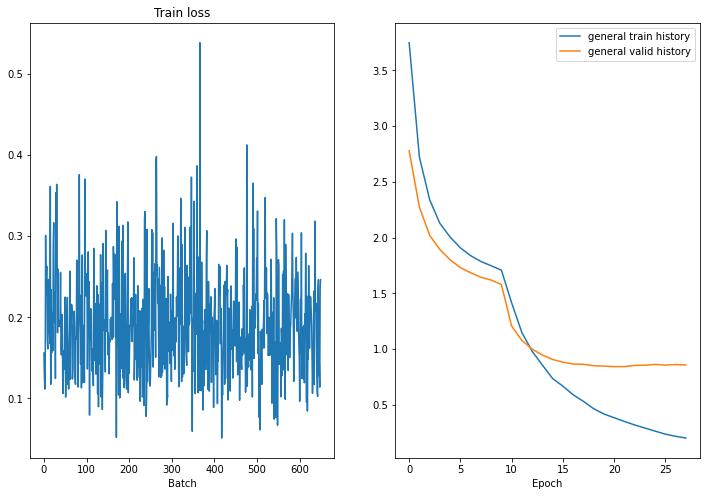

Epoch: 02 | Time: 3m 6s
	Train Loss: 0.196 | Train PPL:   1.216
	 Val. Loss: 0.860 |  Val. PPL:   2.364


In [ ]:
# Дообучение модели занимает примерно 1 час на карточке Tesla T4
train_history = []
valid_history = []

best_valid_loss = float('inf')

for idx in range(len(N_EPOCHS)):
  n_epochs = N_EPOCHS[idx]
  learning_rate = LEARNING_RATE[idx]
  # Если idx=0, то замораживаем веса bert и учим только последний линейный слой
  freeze_all = not bool(idx)
  layer = f'layer.{6-idx}'
  
  if freeze_all:
    model.freeze_bert_encoder()
  else:
    model.unfreeze_bert_encoder(num_layers=[layer])
  
  params = model.parameters()
  optimizer = optim.AdamW(params, lr=learning_rate, weight_decay=1e-4)

  for epoch in range(n_epochs):
      
      start_time = time.time()
      
      train_loss = train(model, train_dataloader, optimizer, criterion, train_history, valid_history)
      valid_loss = evaluate(model, validation_dataloader, criterion)
      
      end_time = time.time()
      
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), MODEL_NAME)
          
      train_history.append(train_loss)
      valid_history.append(valid_loss)
      
      print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
 
  if not freeze_all:
    model.freeze_bert_encoder(num_layers=[layer])

In [ ]:
torch.save(model.state_dict(), MODEL_NAME)

In [ ]:
# Если нет возможности дообучить модель, то можно загрузить уже дообученную
model.load_state_dict(torch.load(MODEL_NAME))

# Расчет метрик

In [ ]:
valid_loss = evaluate(model, validation_dataloader, criterion)
print(valid_loss)

0.860324311653773


In [ ]:
def get_class_for_bert(text, model, tokenizer, dict_labels):
  
  model.eval()
  with torch.no_grad():
    inputs = tokenizer.encode_plus(text, return_tensors="pt").to(device)
    logits = model(inputs)
    sf_logits = F.softmax(logits, 1).squeeze(0)
    class_id = torch.argmax(sf_logits)
    class_id = dict_labels[class_id.detach().cpu().item()]

  return class_id

In [ ]:
X_train['y_pred'] = X_train.item_name.apply(lambda x: get_class_for_bert(x, model, tokenizer, dict_labels))
f1_score(y_train['y_true'].apply(lambda x: dict_labels[x]), X_train['y_pred'], average='weighted')

0.9694307243248218

In [ ]:
X_test['y_pred'] = X_test.item_name.apply(lambda x: get_class_for_bert(x, model, tokenizer, dict_labels))
f1_score(y_test['y_true'].apply(lambda x: dict_labels[x]), X_test['y_pred'], average='weighted')

0.8143120502851494

# Псевдо разметка


Для псевдо разметки используется подход, описанный в статье https://www.aclweb.org/anthology/2020.coling-main.438.pdf.  
Основная идея: 
1. Объединяем размеченные и неразмеченные данные в один набор. 
2. Для каждого item_name получаем векторное представление (используем дообученный bert).
3. Строим дерево при помощи агломеративной кластеризации (объединяем item_name в кластеры пока не получим один кластер).
4. Спускаемся по полученному дереву (по каждой ветке идём до тех пор, пока не останутся объекты только одного класса + неразмеченные, или пока не останутся только неразмеченные объекты).
5. В точке останова неразмеченным объектам, которые находятся в одном кластере с размеченными, присваиваем соответствующий псевдо класс.



In [ ]:
# Определим вспомогательные функции для псевдо разметки
def get_emb_for_item(text, model, tokenizer):
  
  model.eval()
  with torch.no_grad():
    inputs = tokenizer.encode_plus(text, return_tensors="pt").to(device)
    logits, embeddings = model(inputs, return_logits=True)
    
    return embeddings.detach().cpu().numpy()


def create_labels_for_node(model_ac, labeled_dict: dict):
    
    nodes_class = {}
    nodes_leaf = {}

    n_samples = len(model_ac.labels_)
    for i, merge in tqdm(enumerate(model_ac.children_)):
        node_merge_idx = n_samples + i
        for child_idx in merge:
            if child_idx < n_samples:
                if node_merge_idx in nodes_class:
                  nodes_class[node_merge_idx].append(labeled_dict[child_idx])
                  nodes_leaf[node_merge_idx].append(child_idx)
                else:
                  nodes_class[node_merge_idx] = [labeled_dict[child_idx]]
                  nodes_leaf[node_merge_idx] = [child_idx]
            else:
                if node_merge_idx in nodes_class:
                  nodes_class[node_merge_idx].extend(nodes_class[child_idx])
                  nodes_leaf[node_merge_idx].extend(nodes_leaf[child_idx])
                else:
                  nodes_class[node_merge_idx] = nodes_class[child_idx]
                  nodes_leaf[node_merge_idx] = nodes_leaf[child_idx]
    
    return nodes_class, nodes_leaf


def make_pseudo_labeling(nodes_leaf: dict, node_labels: dict, nolab_items_id: list):

    node_labels = {key: [x for x in list(set(node_labels[key])) if x != -1] for key in node_labels}
    node_labels = {key: node_labels[key][0] for key in node_labels if len(node_labels[key]) == 1}
    pseudo_lab = {key: nodes_leaf[key] for key in nodes_leaf if key in node_labels}
    
    pseudo_lab_item = {}
    for node in tqdm(pseudo_lab):
        items = pseudo_lab[node]
        for item in items:
            if (item not in pseudo_lab_item) & (item in nolab_items_id):
                pseudo_lab_item[item] = node_labels[node]

    return pseudo_lab_item


def iter_pseudo(X_true:list, Y_true:list, data_nolabel, iter_of_batch, model_bert, tokenizer, dict_labels, path_to_dir, batch_no_lab=5000):

    for i in tqdm(range(iter_of_batch)):
        data_nolabel_sample = data_nolabel.iloc[i*batch_no_lab:(i+1)*batch_no_lab]
        data_nolabel_sample['embs'] = data_nolabel_sample.item_name.apply(lambda x: get_emb_for_item(x, model_bert, tokenizer))
        for idx, (labeled_x, y) in tqdm(enumerate(zip(X_true, Y_true))):
            df_total = pd.concat([labeled_x, data_nolabel_sample[['item_name',	'embs']]], ignore_index=True)
            labeled_dict = y.y_true.tolist() + data_nolabel_sample.category_id.tolist()
            labeled_dict = dict(zip(df_total.index, labeled_dict))
            nolab_items_id = [key for key in labeled_dict if labeled_dict[key] == -1]
            print('no labeled items: ', len(nolab_items_id))
            cluster_up = AgglomerativeClustering(n_clusters=1)
            cluster_up.fit(np.concatenate(df_total.embs.tolist()))
            node_labels, nodes_leaf = create_labels_for_node(cluster_up, labeled_dict)
            pseudo_lab_dict = make_pseudo_labeling(nodes_leaf, node_labels, nolab_items_id)
            print('pesudo lab count: ', len(pseudo_lab_dict))
            data_nolabel_sample_c = data_nolabel_sample[['item_name']]
            data_nolabel_sample_c['ids'] = nolab_items_id
            data_nolabel_sample_c['y_pseudo'] = data_nolabel_sample_c['ids'].apply(lambda x: pseudo_lab_dict[x] if x in pseudo_lab_dict else np.NaN)
            data_nolabel_sample_c = data_nolabel_sample_c.dropna(subset=['y_pseudo'])
            data_nolabel_sample_c['category_id'] = data_nolabel_sample_c.y_pseudo.apply(lambda x: dict_labels[x])
            if len(data_nolabel_sample_c):
                data_nolabel_sample_c[['item_name',	'category_id']].to_csv(path_to_dir+f'/iter_{i}_true_{idx}.csv', index=False)
                print('file successful wrote.')

In [ ]:
# Разобьем размеченные данные на 4 примерно одинаковые части.
# Такое разбиение выполняется из-за нехватки ОЗУ в google colab. 
# Если есть сервер помощнее, то разбиение можно не выполнять.
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=.75, random_state=SEED, stratify=y_train['y_true'])
X_train_2, X_train_3, y_train_2, y_train_3 = train_test_split(X_train_2, y_train_2, test_size=.6, random_state=SEED, stratify=y_train_2['y_true'])
X_train_3, X_train_4, y_train_3, y_train_4 = train_test_split(X_train_3, y_train_3, test_size=.5, random_state=SEED, stratify=y_train_3['y_true'])

In [ ]:
print(X_train_1.shape, X_train_2.shape, X_train_3.shape, X_train_4.shape)
print(y_train_1.shape, y_train_2.shape, y_train_3.shape, y_train_4.shape)

(10752, 2) (12903, 2) (9678, 2) (9678, 2)
(10752, 1) (12903, 1) (9678, 1) (9678, 1)


In [ ]:
for train_data in [X_train_1, X_train_2, X_train_3, X_train_4]:
  train_data['embs'] = train_data.item_name.apply(lambda x: get_emb_for_item(x, model, tokenizer))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Для соревнования я выполнял псевдо разметку для 240000 неразмеченных данных.
# В одном colab notebook это занимает порядка 9 часов.
# Для демонстрации можно ограничиться 10000.
data_nolabel_sample = data_nolabel.sample(10000, random_state=17)

In [ ]:
path = "pseudo_data/"
!mkdir $path

In [ ]:
%%time
iter_pseudo([X_train_1, X_train_2, X_train_3, X_train_4], 
            [y_train_1, y_train_2, y_train_3, y_train_4], 
            data_nolabel_sample, 2, model, tokenizer, 
            dict_labels, path_to_dir=path, batch_no_lab=5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3794
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3892
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3721
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3755
file successful wrote.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3762
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3810
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3781
file successful wrote.
no labeled items:  5000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



pesudo lab count:  3776
file successful wrote.


CPU times: user 20min 23s, sys: 5.89 s, total: 20min 28s
Wall time: 20min 28s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Обработаем сохраненные файлы с псевдо разметкой. 
# Создадим один pandas DataFrame с псевдо размеченными данными.
iters = {f'iter_{i}': [] for i in range(2)}
for file_n in os.listdir(path):
  iters[file_n.split('_true')[0]].append(file_n)

In [ ]:
dfs = []
for iter in tqdm(iters):
  for idx, file_n in enumerate(iters[iter]):
    try:
      if idx == 0:
        df_iter = pd.read_csv(os.path.join(path, file_n), lineterminator='\n')
      else:
        # Псевдо метку присваиваем только item_name, которые получили
        # метку при кластеризации каждым кусочком размеченных данных. 
        df_iter = df_iter.merge(pd.read_csv(os.path.join(path, file_n), lineterminator='\n'), on='item_name', how='inner')
    except:
      print('error load file: ', os.path.join(path, file_n))
  dfs.append(df_iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# Псевдо метку присваиваем только item_name, которые получили одну
# и туже метку при кластеризации каждым кусочком размеченных данных. 
for idx, df in enumerate(dfs):
  df['category_pred'] = df[[x for x in df if x!='item_name']].apply(lambda x: pd.unique(x.tolist()), axis=1)
  df = df[df.category_pred.apply(len) == 1]
  df['category_pred'] = df['category_pred'].apply(lambda x: x[0])
  
  if idx == 0:
    df_total_pseudo = df[['item_name', 'category_pred']]
  else:
    df_total_pseudo = pd.concat([df_total_pseudo, df[['item_name', 'category_pred']]], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_total_pseudo.drop_duplicates().to_csv(os.path.join('data', "pseudo10000.csv"), index=False)

In [ ]:
df_total_pseudo.drop_duplicates().head(10)

,item_name,category_pred
0,продукт сметанный альпийская коровка 15% 400гр...,78
1,merci шок мол лес орех/минд100г,84
2,1 капотен таб 25мг №40bristol-myer,38
3,пена монтажная профессиональная kudo всесез ho...,114
4,колбаски крымские 2 сорт вма изд из мяса птицы...,74
5,блузка (f032 s 31p0),61
6,колбаса купеческая б/шп 0 5кг 1+1 ю-польский,74
7,салат греческий 190 1 порц,71
8,салат морской невод с креветками,71
9,вафли ореховые 300гр яшкино,84
